<h1>🍺Original dataset:</h1>
https://www.kaggle.com/datasets/nickhould/craft-cans

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, auc
from sklearn. metrics import classification_report

In [4]:
data = pd.read_csv('beers.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2410 entries, 0 to 2409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2410 non-null   int64  
 1   abv         2348 non-null   float64
 2   ibu         1405 non-null   float64
 3   id          2410 non-null   int64  
 4   name        2410 non-null   object 
 5   style       2405 non-null   object 
 6   brewery_id  2410 non-null   int64  
 7   ounces      2410 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 150.8+ KB


In [6]:
data.describe()

,Unnamed: 0,abv,ibu,id,brewery_id,ounces
count,2410.000000,2348.000000,1405.000000,2410.000000,2410.000000,2410.000000
mean,1204.500000,0.059773,42.713167,1431.113278,231.749793,13.592241
std,695.851397,0.013542,25.954066,752.459975,157.685604,2.352204
min,0.000000,0.001000,4.000000,1.000000,0.000000,8.400000
25%,602.250000,0.050000,21.000000,808.250000,93.000000,12.000000
50%,1204.500000,0.056000,35.000000,1453.500000,205.000000,12.000000
75%,1806.750000,0.067000,64.000000,2075.750000,366.000000,16.000000
max,2409.000000,0.128000,138.000000,2692.000000,557.000000,32.000000


In [7]:
data.head(5)

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


<b>Dataset fields description:</b>
<ul>
    <li>"Unnamed: 0" - row number.</li>
    <li>"abv" - The alcoholic content by volume with 0 being no alcohol and 1 being pure alcohol.</li>
    <li>"ibu" - International bittering units, which describe how bitter a drink is.</li>
    <li>"id" - Unique ID</li>
    <li>"name" - Name of the beer.</li>
    <li>"style" - Beer style (lager, ale, IPA, etc.)(<u>Target!</u>)</li>
    <li>"brewery_id" - Unique identifier for brewery that produces this beer; can use to join with brewery info.</li>
    <li>"ounces" - Size of beer in ounces.</li>
</ul>

<b>See how much unique targets we have:</b>

In [8]:
data['style'].describe()

count             2405
unique              99
top       American IPA
freq               424
Name: style, dtype: object

In [9]:
unique_targets = data['style'].value_counts()
unique_targets

style
American IPA                      424
American Pale Ale (APA)           245
American Amber / Red Ale          133
American Blonde Ale               108
American Double / Imperial IPA    105
                                 ... 
American Malt Liquor                1
Wheat Ale                           1
Flanders Red Ale                    1
Kristalweizen                       1
Low Alcohol Beer                    1
Name: count, Length: 99, dtype: int64

Seems like we will use label encoding...

✋Before encoding lets save in another DataFrame with NaN in style column.<br>
We will use this data later, when we finish training of our models.

In [10]:
unmarked_data = data[data['style'].isna()]
# unmarked_data.index
data = data.drop(unmarked_data.index)

And see another NaN values.

❌Check:

In [11]:
data.isna().any().any()

True

In [12]:
cols_with_miss = {}
for column in data.columns:
    if data[column][data[column].isna() == True].shape[0]:
        cols_with_miss[column] = data[column][data[column].isna() == True].shape[0]
cols_with_miss

{'abv': 59, 'ibu': 1002}

💡Okay, lets try to replace it with average vals in classes.

In [13]:
classes = data['style'].unique()
abv_average, ibu_average = {}, {}
for cl in classes:
    abv_average[cl] = data['abv'][data['style'] == cl].mean()
    # if average ibu is None - let it be 0(it is good representation for sweet sorts)
    ibu_mean = data['ibu'][data['style'] == cl].mean()
    ibu_average[cl] = ibu_mean if ibu_mean > 0 else 0

🧐And see on graphics of our distributions.

In [14]:
vizual_ibu = pd.DataFrame(data={'sort': ibu_average.keys(), 'ibu': ibu_average.values()})
vizual_ibu = vizual_ibu.sort_values(by='ibu', ascending=False)

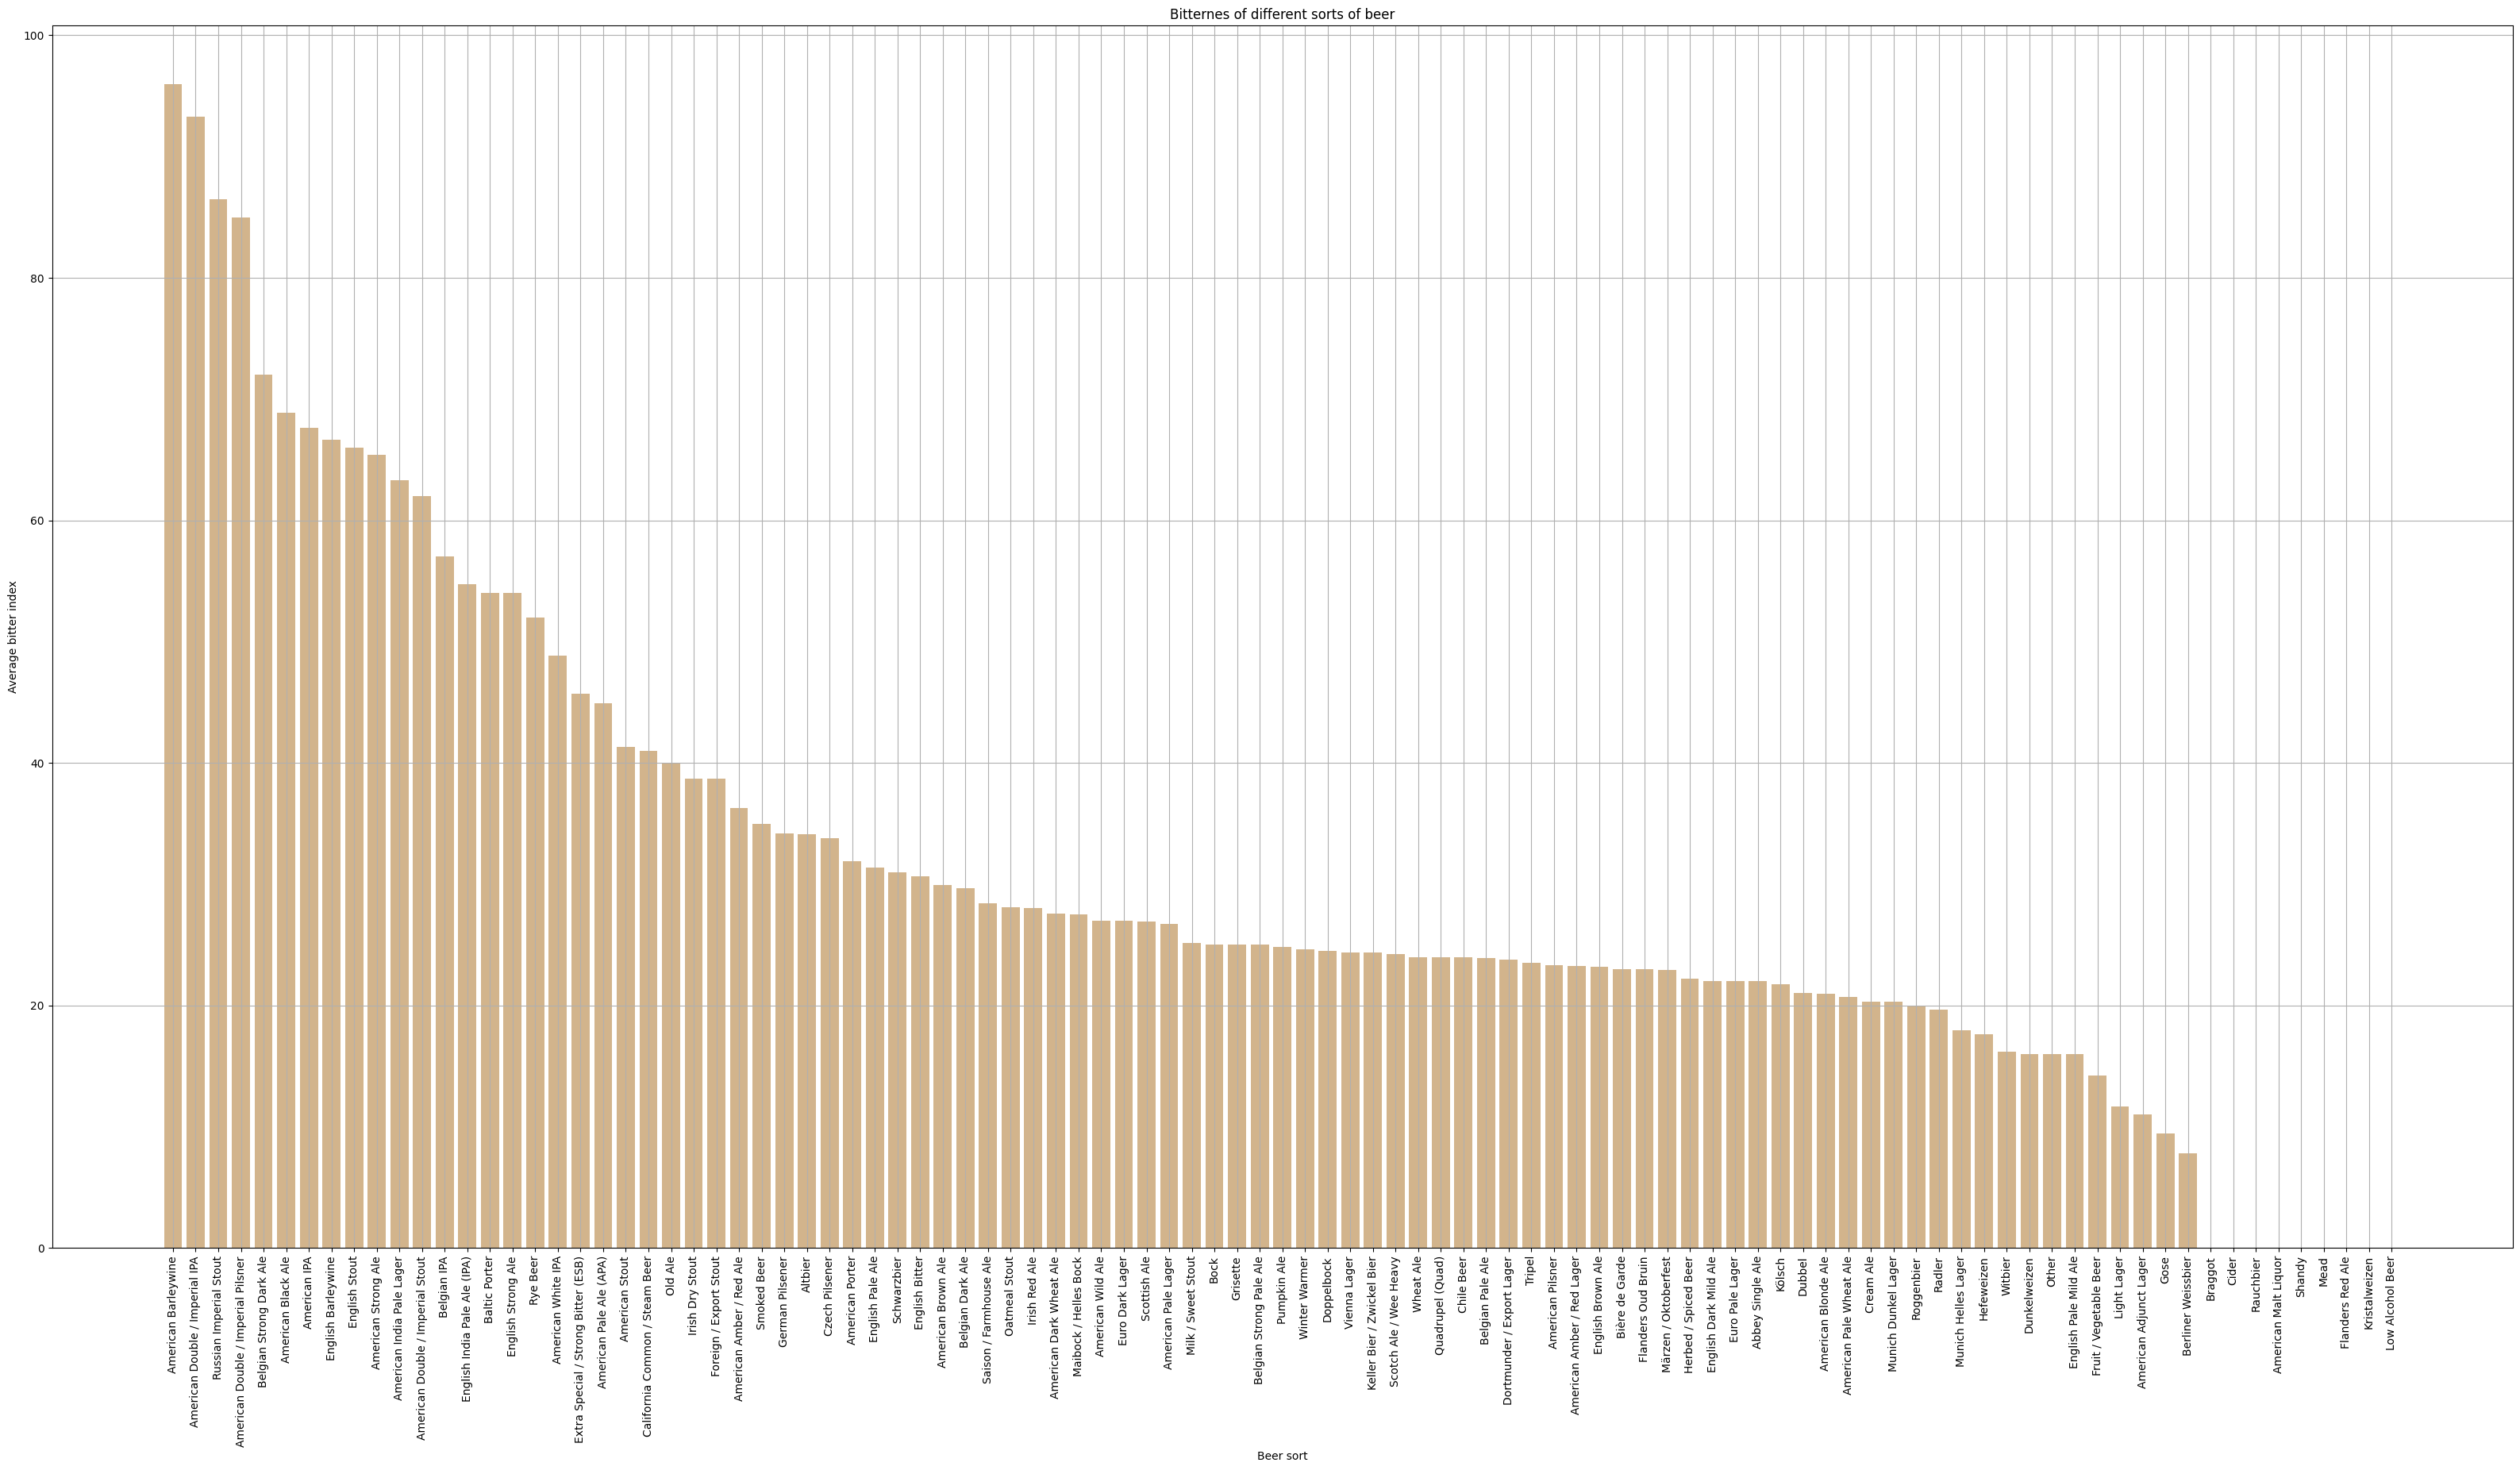

In [15]:
fig, ax = plt.subplots(figsize = (40,20))
ax.bar(vizual_ibu['sort'], vizual_ibu['ibu'], color='tan')
ax.grid(True)
plt.xticks(rotation=90)
plt.xlabel('Beer sort')
plt.ylabel('Average bitter index')
plt.title('Bitternes of different sorts of beer')
plt.show()

In [16]:
vizual_abv = pd.DataFrame(data={'sort': abv_average.keys(), 'abv': abv_average.values()})
vizual_abv = vizual_abv.sort_values(by='abv', ascending=False)

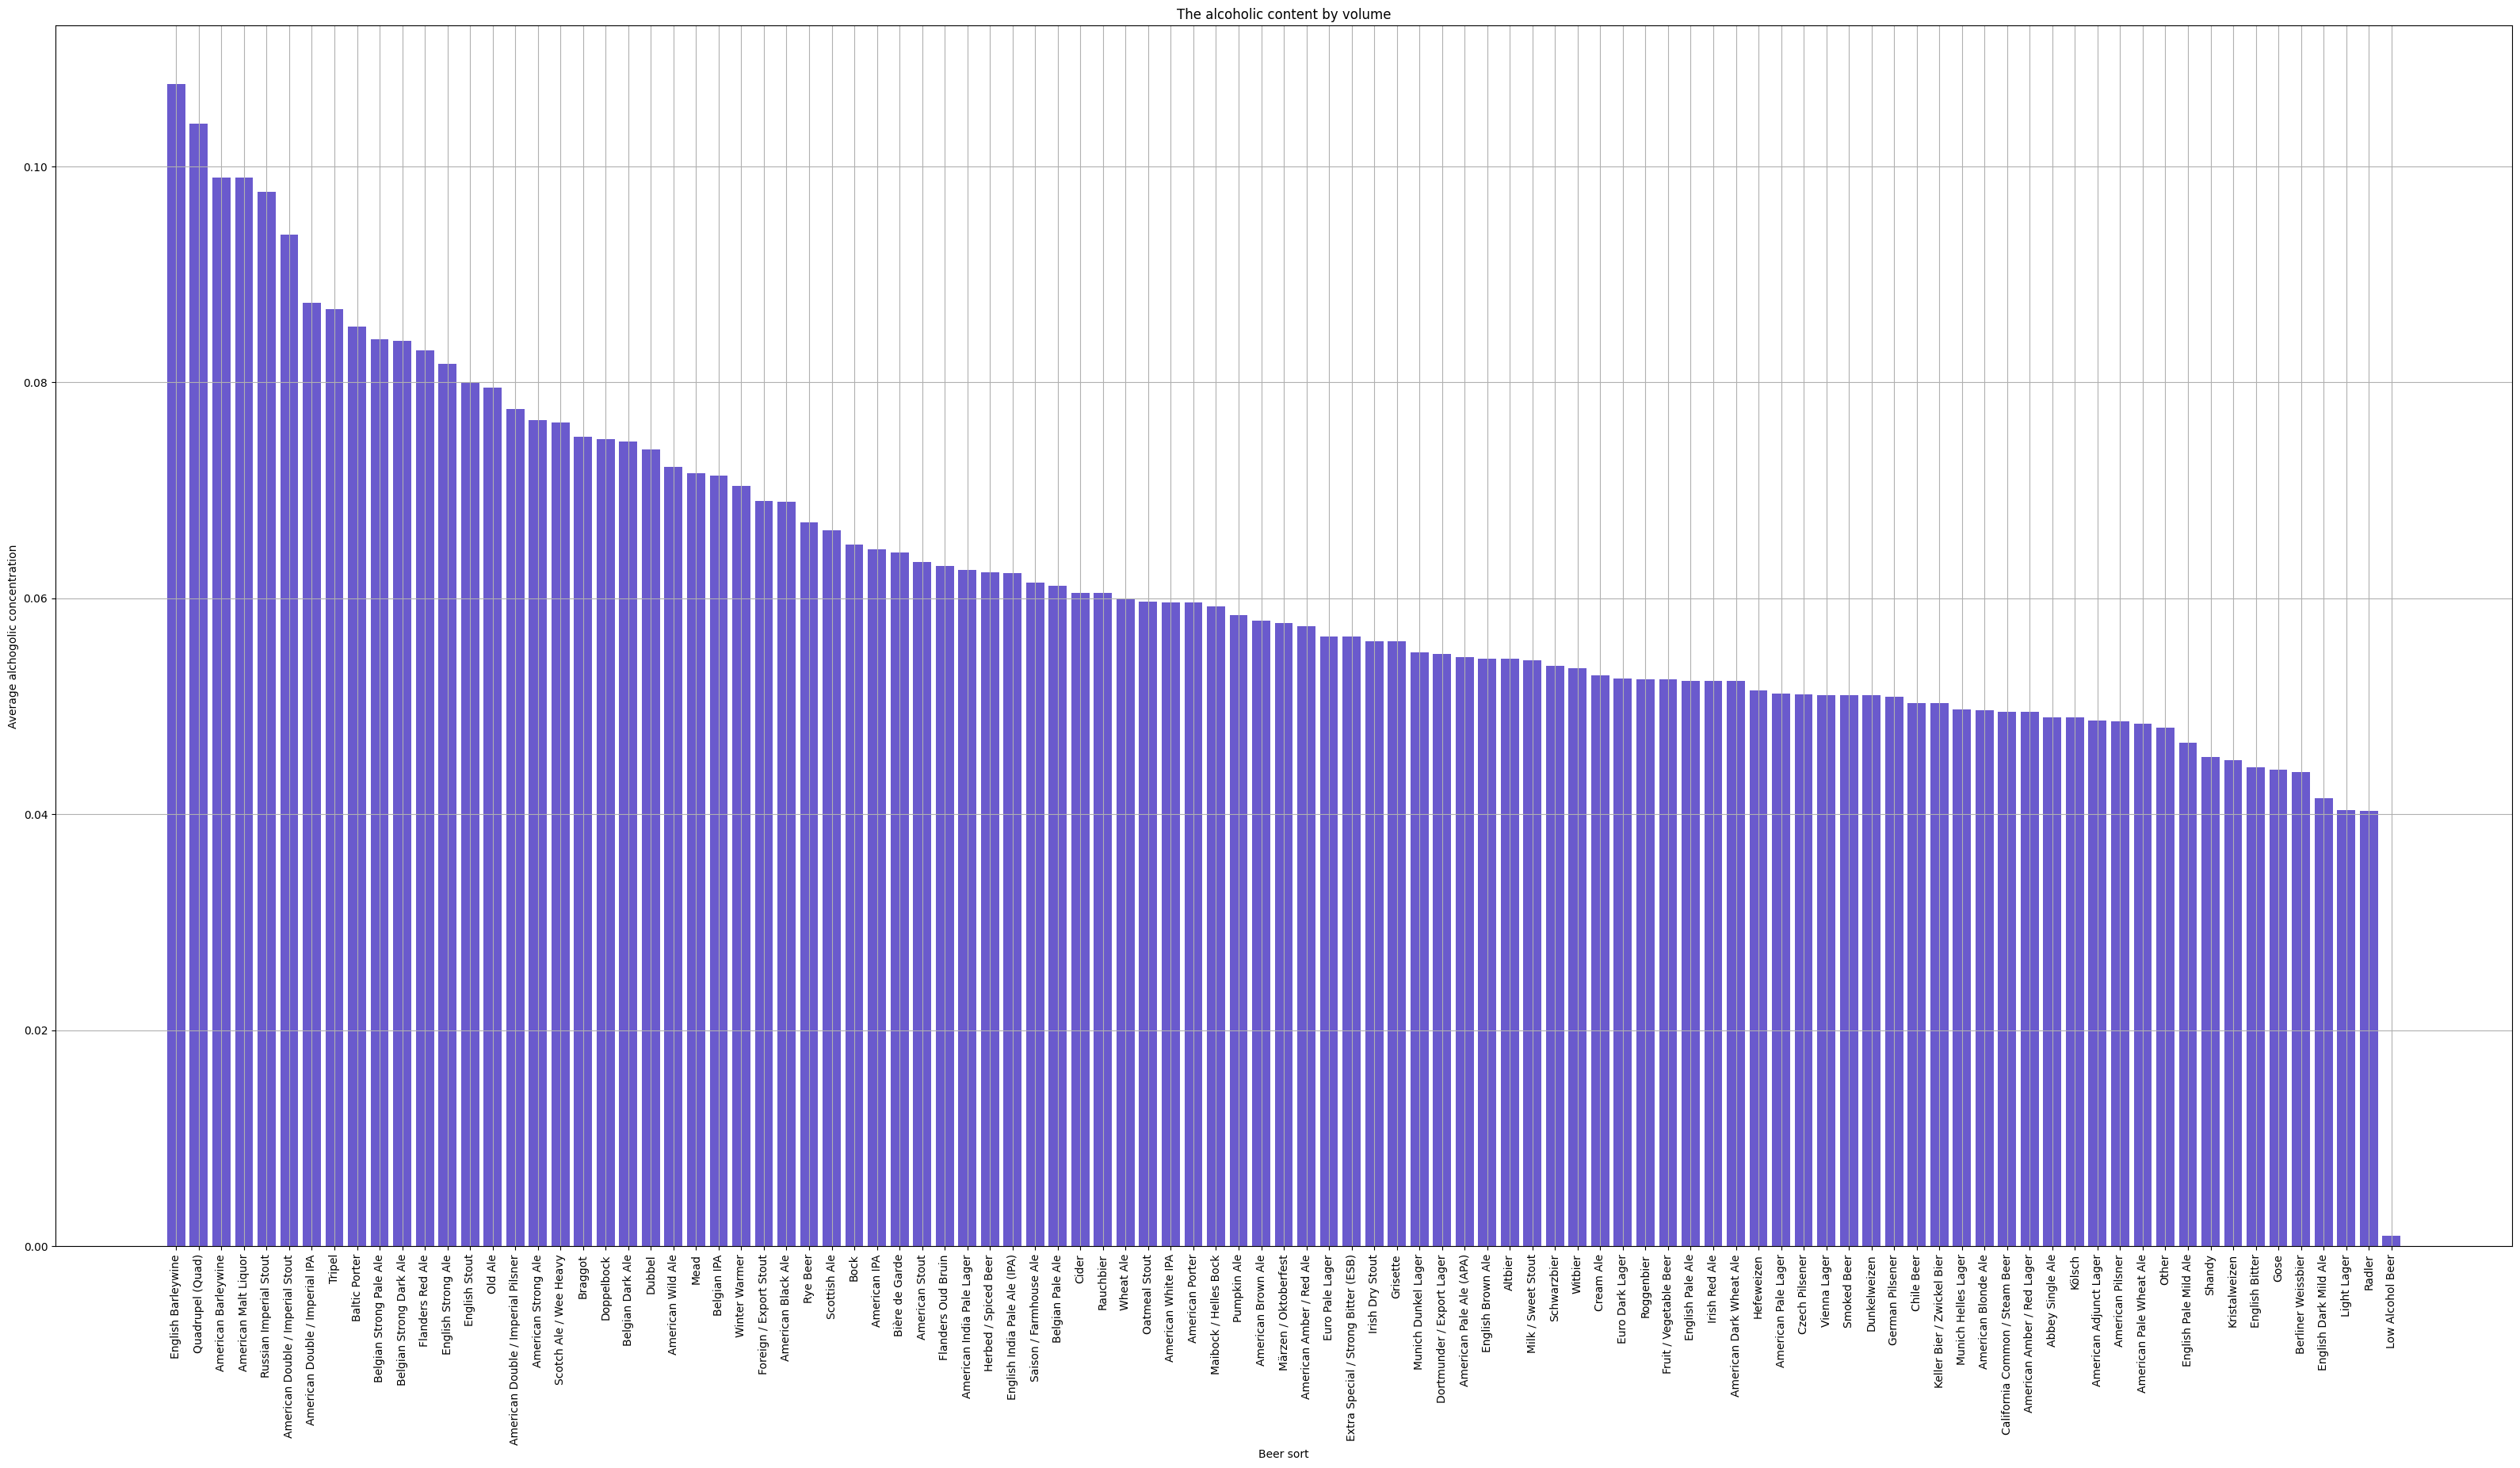

In [17]:
fig, ax = plt.subplots(figsize = (40,20))
ax.bar(vizual_abv['sort'], vizual_abv['abv'], color='slateblue')
ax.grid(True)
plt.xticks(rotation=90)
plt.xlabel('Beer sort')
plt.ylabel('Average alchogolic concentration')
plt.title('The alcoholic content by volume')
plt.show()

In [18]:
data.shape[0]

2405

In [19]:
data.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0


In [20]:
# don't in range(data.shape[0]) because we saved some indexes in unmarked_data
for row in data.index:
    if np.nan_to_num(data.loc[row, ['ibu']].iloc[0]) == 0:
        data.loc[row, ['ibu']] = ibu_average[data.loc[row, ['style']].iloc[0]]
    if np.nan_to_num(data.loc[row, ['abv']].iloc[0]) == 0:
        data.loc[row, ['abv']] = abv_average[data.loc[row, ['style']].iloc[0]]
data.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,26.750000,1436,Pub Beer,American Pale Lager,408,12.0
1,1,0.066,44.941176,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,2,0.071,67.634551,2264,Rise of the Phoenix,American IPA,177,12.0
3,3,0.090,93.320000,2263,Sinister,American Double / Imperial IPA,177,12.0
4,4,0.075,67.634551,2262,Sex and Candy,American IPA,177,12.0


In [21]:
data.isna().any().any()

False

✅Before code - lets think, how we can join our beer's in similar styles group.<br>
Do vizualization first.<br>
See if we have dependences between abv and ibu.

In [22]:
comp_abv = {}
for cl in ibu_average.keys():
    comp_abv[cl] = abv_average[cl]
comp_abv = np.array(list(comp_abv.values())) * 100
comparison = pd.DataFrame(data={'style': ibu_average.keys(), 'ibu_avg': ibu_average.values(), 'abv_avg': comp_abv})
comparison = comparison.sort_values(by='abv_avg', ascending=False)
comparison

,style,ibu_avg,abv_avg
27,English Barleywine,66.666667,10.766667
71,Quadrupel (Quad),24.000000,10.400000
11,American Barleywine,96.000000,9.900000
92,American Malt Liquor,0.000000,9.900000
72,Russian Imperial Stout,86.500000,9.763636
...,...,...,...
20,Berliner Weissbier,7.800000,4.390909
63,English Dark Mild Ale,22.000000,4.150000
79,Light Lager,11.666667,4.041667
61,Radler,19.666667,4.033333


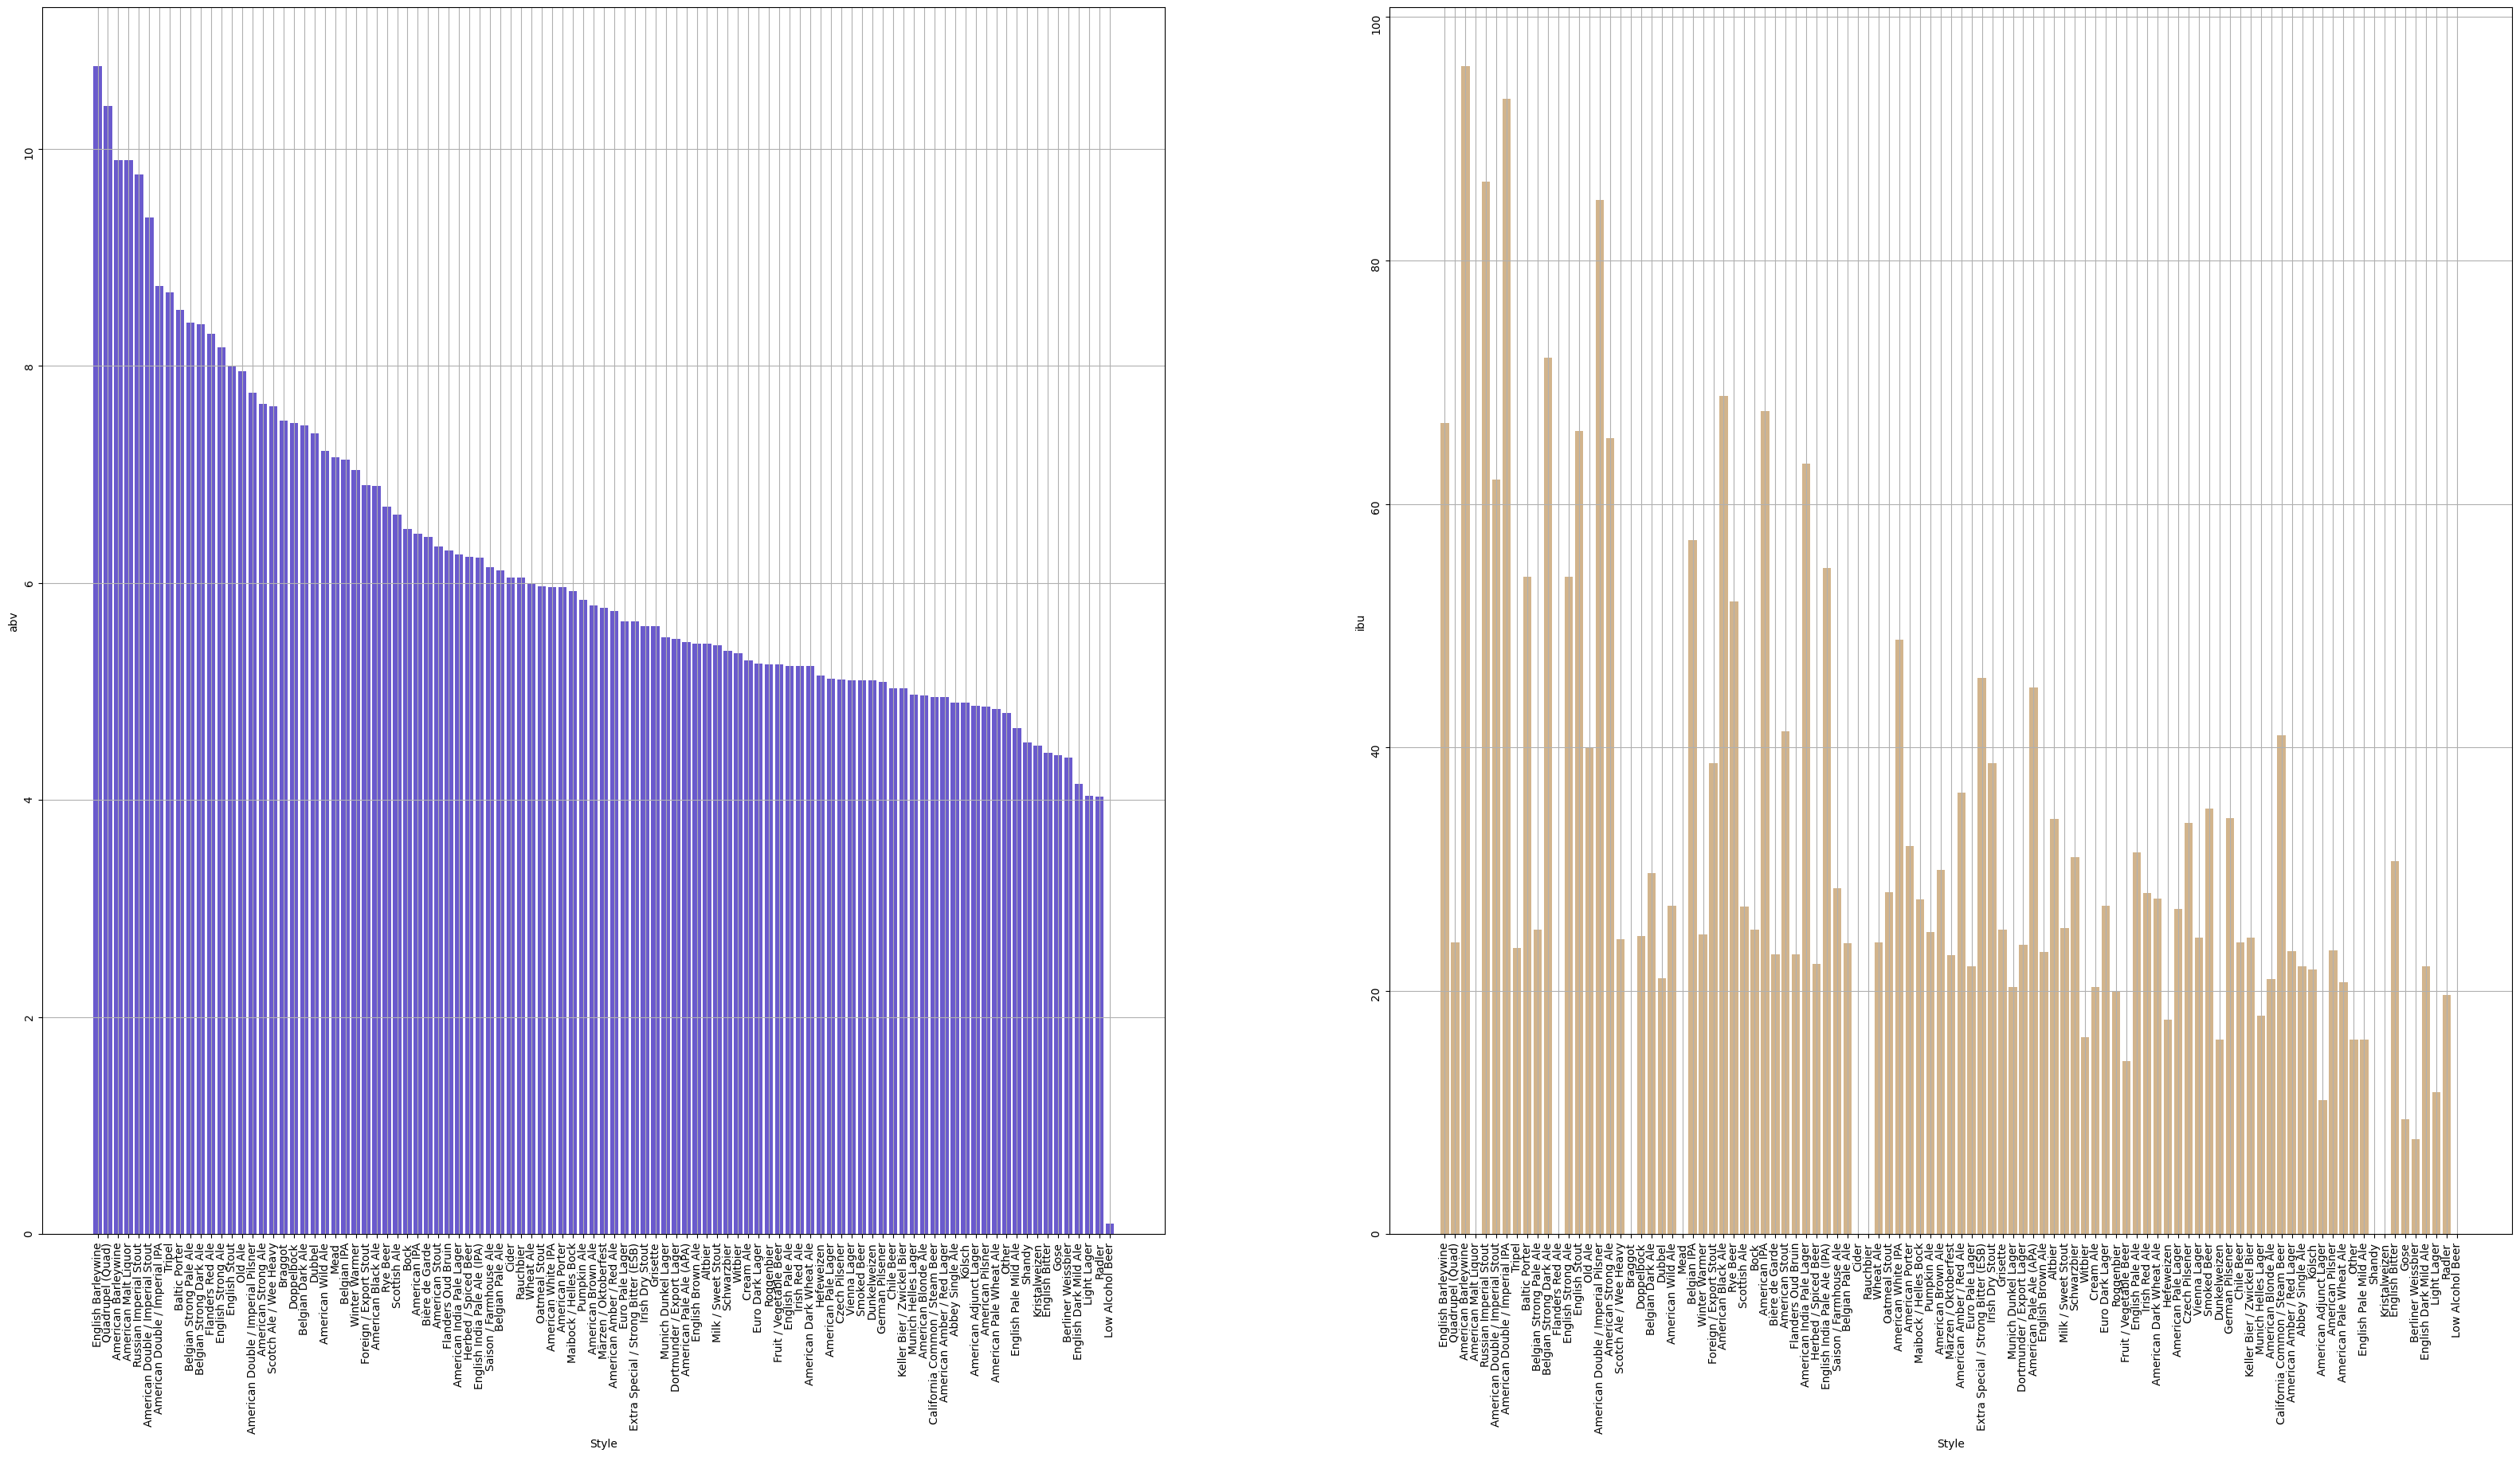

In [23]:
fig, ax = plt.subplots(ncols=2, figsize = (40,20))
ax[0].tick_params(labelrotation=90)
ax[1].tick_params(labelrotation=90)
ax[0].bar(comparison['style'], comparison['abv_avg'], color='slateblue')
ax[1].bar(comparison['style'], comparison['ibu_avg'], color='tan')
ax[0].grid(True)
ax[1].grid(True)
ax[0].set_xlabel('Style')
ax[1].set_xlabel('Style')
ax[0].set_ylabel('abv')
ax[1].set_ylabel('ibu')
plt.show()

✅Well, there is no dependence. Then we will stick to the following strategy - we will break all beers into three main types: ale, mixed and lager.<br>
First, do it by names.

In [24]:
ale_sorts, lager_sorts, mixed = [], [], []
for cl in classes:
    # IPA - indian pale ale, APA - american pale ale
    if ' Ale' in cl or ' ale' in cl or ' IPA' in cl or ' APA' in cl\
    or ' Porter' in cl or ' porter' in cl or ' Stout' in cl or ' stout' in cl or 'Dunkelweizen' in cl\
    or 'Tripel' in cl or 'Kölsch' in cl or ' Barleywine' in cl or 'Witbier' in cl or 'Weiss' in cl\
    or 'Bitter' in cl or 'Winter Warmer' in cl or 'Altbier' in cl or 'Gose' in cl or 'Bière de Garde' in cl\
    or 'Dubbel' in cl or 'Quadrupel (Quad)' in cl or 'Kristalweizen' in cl or 'Grisette' in cl or 'Flanders Oud Bruin' in cl:
        ale_sorts.append(cl)
    elif ' Lager' in cl or ' lager' in cl or ' Light' in cl or ' light' in cl or 'Schwarzbier' in cl or 'Bock' in cl\
    or 'bock' in cl or ' bock' in cl or ' Pilsner' in cl or ' Pilsener' in cl or ' Oktoberfest' in cl or 'Herbed / Spiced Beer' in cl\
    or 'American Malt Liquor' in cl:
        lager_sorts.append(cl)
    else:
        mixed.append(cl)

✅Join our styles in three classes and code our target value!<br>
<ul>
    <li>Ale - 1</li>
    <li>Lager - 2</li>
    <li>Mixed - 3</li>
</ul>

In [25]:
data_coded = data.copy()
for row in data_coded.index:
    if data_coded.loc[row, ['style']].iloc[0] in ale_sorts:
        data_coded.loc[row, ['style']] = 1
    elif data_coded.loc[row, ['style']].iloc[0] in lager_sorts:
        data_coded.loc[row, ['style']] = 2
    else:
        data_coded.loc[row, ['style']] = 3
data_coded.head()

,Unnamed: 0,abv,ibu,id,name,style,brewery_id,ounces
0,0,0.050,26.750000,1436,Pub Beer,2,408,12.0
1,1,0.066,44.941176,2265,Devil's Cup,1,177,12.0
2,2,0.071,67.634551,2264,Rise of the Phoenix,1,177,12.0
3,3,0.090,93.320000,2263,Sinister,1,177,12.0
4,4,0.075,67.634551,2262,Sex and Candy,1,177,12.0


✅See on class balance and average class features.

In [26]:
data_coded['style'].value_counts()

style
1    1913
2     317
3     175
Name: count, dtype: int64

Text(0.5, 1.0, 'Average ounces')

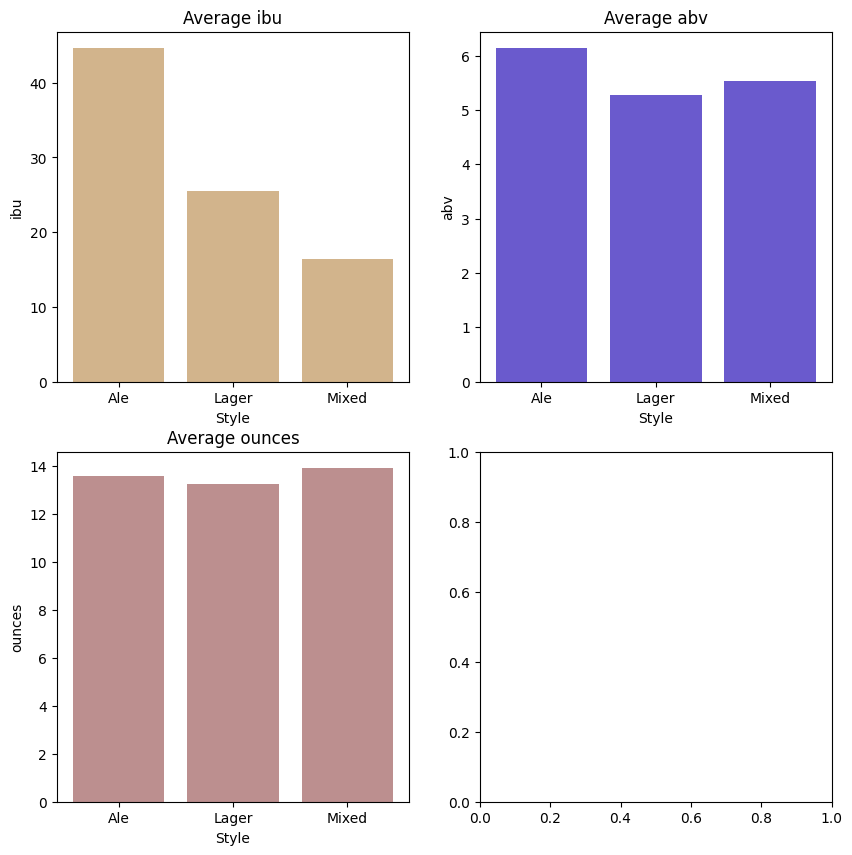

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize = (10,10))
# ibu
ax[0][0].bar(['Ale', 'Lager', 'Mixed'], height=[
    data_coded[data_coded['style'] == 1]['ibu'].mean(),
    data_coded[data_coded['style'] == 2]['ibu'].mean(),
    data_coded[data_coded['style'] == 3]['ibu'].mean()
], color='tan')
ax[0][0].set_xlabel('Style')
ax[0][0].set_ylabel('ibu')
ax[0][0].set_title('Average ibu')
# alchogol
ax[0][1].bar(['Ale', 'Lager', 'Mixed'], height=[
    data_coded[data_coded['style'] == 1]['abv'].mean() * 100,
    data_coded[data_coded['style'] == 2]['abv'].mean() * 100,
    data_coded[data_coded['style'] == 3]['abv'].mean() * 100
], color='slateblue')
ax[0][1].set_xlabel('Style')
ax[0][1].set_ylabel('abv')
ax[0][1].set_title('Average abv')
# ounces
ax[1][0].bar(['Ale', 'Lager', 'Mixed'], height=[
    data_coded[data_coded['style'] == 1]['ounces'].mean(),
    data_coded[data_coded['style'] == 2]['ounces'].mean(),
    data_coded[data_coded['style'] == 3]['ounces'].mean()
], color='rosybrown')
ax[1][0].set_xlabel('Style')
ax[1][0].set_ylabel('ounces')
ax[1][0].set_title('Average ounces')

✅And finally clear our data(drop columns name and Unnamed). Then save it in another file.

In [28]:
data_cleared = data_coded.drop(['Unnamed: 0', 'name', 'id', 'brewery_id'], axis=1)
data_cleared.head()

,abv,ibu,style,ounces
0,0.050,26.750000,2,12.0
1,0.066,44.941176,1,12.0
2,0.071,67.634551,1,12.0
3,0.090,93.320000,1,12.0
4,0.075,67.634551,1,12.0


✅Let's look at the distribution of classes based on ibu and abv.

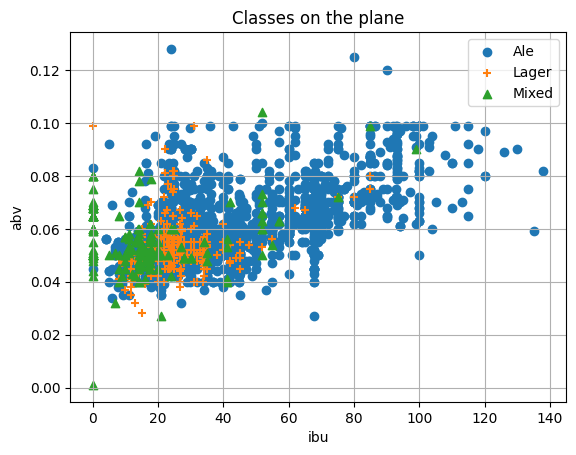

In [33]:
ale_ibu = data_cleared[data_cleared['style'] == 1]['ibu']
ale_abv = data_cleared[data_cleared['style'] == 1]['abv']
lager_ibu = data_cleared[data_cleared['style'] == 2]['ibu']
lager_abv = data_cleared[data_cleared['style'] == 2]['abv']
mixed_ibu = data_cleared[data_cleared['style'] == 3]['ibu']
mixed_abv = data_cleared[data_cleared['style'] == 3]['abv']

plt.scatter(ale_ibu, ale_abv, label='Ale', marker='o')
plt.scatter(lager_ibu, lager_abv, label='Lager', marker='+')
plt.scatter(mixed_ibu, mixed_abv, label='Mixed', marker='^')
plt.title('Classes on the plane')
plt.xlabel('ibu')
plt.ylabel('abv')
plt.legend()
plt.grid()
plt.show()

🥲It seems like we have a difficult classification case.<br>
Lets try to train our models!<br>
We will use four models - KNN, Trees, LogisticRegression and SVM

✅Split our data with stratify option.

In [34]:
y = data_cleared['style'].astype(int)
X = data_cleared.drop(['style'], axis=1)
y.shape, X.shape

((2405,), (2405, 3))

In [35]:
# scale our features first
scl = StandardScaler()
X = scl.fit_transform(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=8)

✅Start train our models.

✅Start with KNN classifier.

✅Find best KNN params.

In [37]:
knn_parameters = {'weights': ('uniform', 'distance'), 'n_neighbors': np.arange(5, 101, 5)}
# f1_micro - mirco average
best_knn_search = GridSearchCV(KNeighborsClassifier(), knn_parameters, scoring='f1_micro')
best_knn_search.fit(X_train, y_train)
params = best_knn_search.best_estimator_.get_params()

In [38]:
best_knn = KNeighborsClassifier(**params)

In [39]:
oneVSrestStrategy = OneVsRestClassifier(best_knn)
oneVSrestStrategy.fit(X_train, y_train)
oneVSrestStrategy_pred = oneVSrestStrategy.predict(X_test)

✅See on metrics.

In [40]:
# binaryze our multiclass targets into binary
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
knn_onehot_pred = label_binarizer.transform(oneVSrestStrategy_pred)

In [41]:
# See on Ale(class 1) metrics first
intrested_class = 1
# Take index in binarizes classes.
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [42]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))

Precision for class 1 0.8582677165354331
Recall for class 1 0.9494773519163763
F1 for class 1 0.901571546732837


In [43]:
# and the same for Laer and mixed:
# Lager(class 2)
intrested_class = 2
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [45]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))

Precision for class 2 0.6363636363636364
Recall for class 2 0.3684210526315789
F1 for class 2 0.4666666666666667


In [48]:
# and the same for Laer and mixed:
# Mixed(class 3)
intrested_class = 3
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [49]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], knn_onehot_pred[:, class_id]))

Precision for class 3 0.625
Recall for class 3 0.37735849056603776
F1 for class 3 0.4705882352941177


✅See on classifier hyperplane.

In [50]:
# Extract features
abv_cl_1 = X_test[:, 0]
ibu_cl_1 = X_test[:, 1]
abv_cl_2 = X_test[:, 0]
ibu_cl_2 = X_test[:, 1]
abv_cl_3 = X_test[:, 0]
ibu_cl_3 = X_test[:, 1]

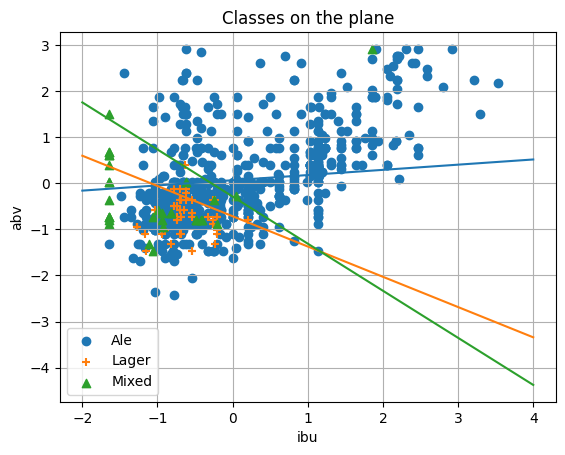

In [51]:
x = np.arange(-2, 5, 1)
plt.scatter(ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)], abv_cl_1[np.where(oneVSrestStrategy_pred == 1)], label='Ale', marker='o')
plt.scatter(ibu_cl_2[np.where(oneVSrestStrategy_pred == 2)], abv_cl_2[np.where(oneVSrestStrategy_pred == 2)], label='Lager', marker='+')
plt.scatter(ibu_cl_3[np.where(oneVSrestStrategy_pred == 3)], abv_cl_3[np.where(oneVSrestStrategy_pred == 3)], label='Mixed', marker='^')
# draw clf hyperplanes
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean())
plt.title('Classes on the plane')
plt.xlabel('ibu')
plt.ylabel('abv')
plt.legend()
plt.grid()
plt.show()

✅Continue with LogisticRegression.

In [52]:
# penalty - regularization
# C - regulrization parameter
# l1_ratio - for elasticnet, 0 <= l1_ratio <= 1, 0 equal l2, 1 equal l1
logit_parameters = {'l1_ratio': np.arange(0, 1.1, 0.1), 'C': (0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0),
                   'max_iter': (100, 200, 300, 400, 500)}
# f1_micro - mirco average
best_logit_search = GridSearchCV(LogisticRegression(class_weight='balanced', solver='saga', penalty='elasticnet', multi_class='ovr'), logit_parameters, scoring='f1_micro')
best_logit_search.fit(X_train, y_train)
params = best_logit_search.best_estimator_.get_params()

In [53]:
best_logit = LogisticRegression(**params)

In [54]:
oneVSrestStrategy = OneVsRestClassifier(best_logit)
oneVSrestStrategy.fit(X_train, y_train)
oneVSrestStrategy_pred = oneVSrestStrategy.predict(X_test)

In [55]:
# binaryze our multiclass targets into binary
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
logit_onehot_pred = label_binarizer.transform(oneVSrestStrategy_pred)

In [56]:
# See on Ale(class 1) metrics first
intrested_class = 1
# Take index in binarizes classes.
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [57]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))

Precision for class 1 0.9510869565217391
Recall for class 1 0.6097560975609756
F1 for class 1 0.7430997876857749


In [58]:
# and the same for Laer and mixed:
# Lager(class 2)
intrested_class = 2
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [59]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))

Precision for class 2 0.24555160142348753
Recall for class 2 0.7263157894736842
F1 for class 2 0.3670212765957446


In [60]:
# and the same for Laer and mixed:
# Mixed(class 3)
intrested_class = 3
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [61]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))

Precision for class 3 0.2876712328767123
Recall for class 3 0.39622641509433965
F1 for class 3 0.33333333333333337


✅See on classifier hyperplane.

In [62]:
# Extract features
abv_cl_1 = X_test[:, 0]
ibu_cl_1 = X_test[:, 1]
abv_cl_2 = X_test[:, 0]
ibu_cl_2 = X_test[:, 1]
abv_cl_3 = X_test[:, 0]
ibu_cl_3 = X_test[:, 1]

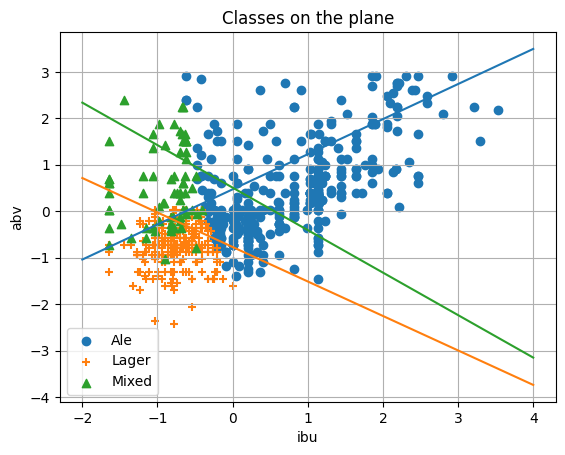

In [63]:
x = np.arange(-2, 5, 1)
plt.scatter(ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)], abv_cl_1[np.where(oneVSrestStrategy_pred == 1)], label='Ale', marker='o')
plt.scatter(ibu_cl_2[np.where(oneVSrestStrategy_pred == 2)], abv_cl_2[np.where(oneVSrestStrategy_pred == 2)], label='Lager', marker='+')
plt.scatter(ibu_cl_3[np.where(oneVSrestStrategy_pred == 3)], abv_cl_3[np.where(oneVSrestStrategy_pred == 3)], label='Mixed', marker='^')
# draw clf hyperplanes
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean())
plt.title('Classes on the plane')
plt.xlabel('ibu')
plt.ylabel('abv')
plt.legend()
plt.grid()
plt.show()

✅Continue with SVC.

In [93]:
svc_parameters = {'C': (0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 2.0, 3.0)}
# f1_micro - mirco average
best_svc_search = GridSearchCV(SVC(class_weight='balanced', decision_function_shape='ovr', break_ties=True), svc_parameters, scoring='f1_micro')
best_svc_search.fit(X_train, y_train)
params = best_svc_search.best_estimator_.get_params()

In [94]:
best_svc = SVC(**params)

In [95]:
oneVSrestStrategy = OneVsRestClassifier(best_svc)
oneVSrestStrategy.fit(X_train, y_train)
oneVSrestStrategy_pred = oneVSrestStrategy.predict(X_test)

In [96]:
# binaryze our multiclass targets into binary
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
svc_onehot_pred = label_binarizer.transform(oneVSrestStrategy_pred)

In [97]:
# See on Ale(class 1) metrics first
intrested_class = 1
# Take index in binarizes classes.
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [98]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))

Precision for class 1 0.9495548961424333
Recall for class 1 0.5574912891986062
F1 for class 1 0.7025246981339187


In [99]:
# and the same for Laer and mixed:
# Lager(class 2)
intrested_class = 2
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [100]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], svc_onehot_pred[:, class_id]))

Precision for class 2 0.22580645161290322
Recall for class 2 0.7368421052631579
F1 for class 2 0.345679012345679


In [101]:
# and the same for Laer and mixed:
# Mixed(class 3)
intrested_class = 3
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [102]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], logit_onehot_pred[:, class_id]))

Precision for class 3 0.2876712328767123
Recall for class 3 0.39622641509433965
F1 for class 3 0.33333333333333337


✅See on classifier hyperplane.

In [103]:
# Extract features
abv_cl_1 = X_test[:, 0]
ibu_cl_1 = X_test[:, 1]
abv_cl_2 = X_test[:, 0]
ibu_cl_2 = X_test[:, 1]
abv_cl_3 = X_test[:, 0]
ibu_cl_3 = X_test[:, 1]

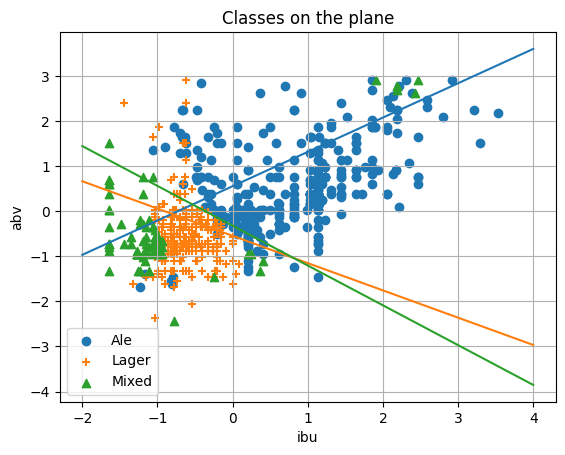

In [104]:
x = np.arange(-2, 5, 1)
plt.scatter(ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)], abv_cl_1[np.where(oneVSrestStrategy_pred == 1)], label='Ale', marker='o')
plt.scatter(ibu_cl_2[np.where(oneVSrestStrategy_pred == 2)], abv_cl_2[np.where(oneVSrestStrategy_pred == 2)], label='Lager', marker='+')
plt.scatter(ibu_cl_3[np.where(oneVSrestStrategy_pred == 3)], abv_cl_3[np.where(oneVSrestStrategy_pred == 3)], label='Mixed', marker='^')
# draw clf hyperplanes
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean())
plt.title('Classes on the plane')
plt.xlabel('ibu')
plt.ylabel('abv')
plt.legend()
plt.grid()
plt.show()

✅Continue with trees.

In [106]:
tree_parameters = {'max_depth': (5, 6, 7, 8, 9, 10), 'min_samples_split': (2, 3, 4, 5), 'min_samples_leaf': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}
# f1_micro - mirco average
best_tree_search = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), tree_parameters, scoring='f1_micro')
best_tree_search.fit(X_train, y_train)
params = best_tree_search.best_estimator_.get_params()

In [107]:
best_tree = DecisionTreeClassifier(**params)

In [108]:
oneVSrestStrategy = OneVsRestClassifier(best_tree)
oneVSrestStrategy.fit(X_train, y_train)
oneVSrestStrategy_pred = oneVSrestStrategy.predict(X_test)

In [109]:
# binaryze our multiclass targets into binary
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
tree_onehot_pred = label_binarizer.transform(oneVSrestStrategy_pred)

In [110]:
# See on Ale(class 1) metrics first
intrested_class = 1
# Take index in binarizes classes.
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [111]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))

Precision for class 1 0.9368191721132898
Recall for class 1 0.7491289198606271
F1 for class 1 0.8325266214908035


In [112]:
# and the same for Laer and mixed:
# Lager(class 2)
intrested_class = 2
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [113]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))

Precision for class 2 0.3620689655172414
Recall for class 2 0.6631578947368421
F1 for class 2 0.46840148698884754


In [114]:
# and the same for Laer and mixed:
# Mixed(class 3)
intrested_class = 3
class_id = np.flatnonzero(label_binarizer.classes_ == intrested_class)[0]

In [116]:
print(f'Precision for class {intrested_class}', precision_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'Recall for class {intrested_class}', recall_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))
print(f'F1 for class {intrested_class}', f1_score(y_onehot_test[:, class_id], tree_onehot_pred[:, class_id]))

Precision for class 3 0.33707865168539325
Recall for class 3 0.5660377358490566
F1 for class 3 0.42253521126760557


In [117]:
# Extract features
abv_cl_1 = X_test[:, 0]
ibu_cl_1 = X_test[:, 1]
abv_cl_2 = X_test[:, 0]
ibu_cl_2 = X_test[:, 1]
abv_cl_3 = X_test[:, 0]
ibu_cl_3 = X_test[:, 1]

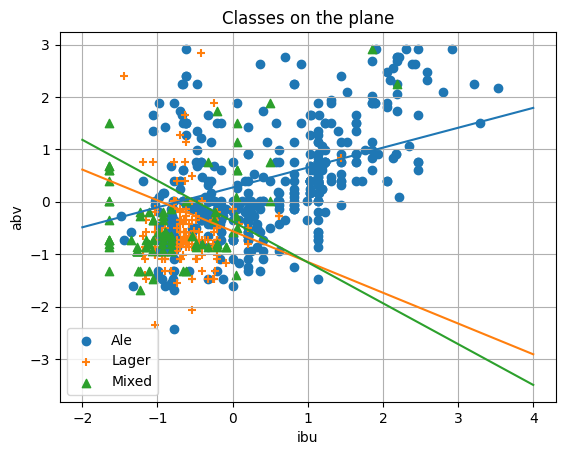

In [118]:
x = np.arange(-2, 5, 1)
plt.scatter(ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)], abv_cl_1[np.where(oneVSrestStrategy_pred == 1)], label='Ale', marker='o')
plt.scatter(ibu_cl_2[np.where(oneVSrestStrategy_pred == 2)], abv_cl_2[np.where(oneVSrestStrategy_pred == 2)], label='Lager', marker='+')
plt.scatter(ibu_cl_3[np.where(oneVSrestStrategy_pred == 3)], abv_cl_3[np.where(oneVSrestStrategy_pred == 3)], label='Mixed', marker='^')
# draw clf hyperplanes
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 1)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 2)].mean())
plt.plot(x, x * ibu_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean() + abv_cl_1[np.where(oneVSrestStrategy_pred == 3)].mean())
plt.title('Classes on the plane')
plt.xlabel('ibu')
plt.ylabel('abv')
plt.legend()
plt.grid()
plt.show()

✅So, the beer task turned out to be more difficult. The main difficulty was the classes nested in each other and the small number of significant features. KNN and DecisionTree turned out to be the most suitable models for this situation.